# Auswertung 200214_2

### imports

In [2]:
import matplotlib.pyplot as plt
from readTrc import Trc
import numpy as np
import h5py
import json
from datetime import *
from os import listdir
from os.path import abspath, isfile, join
import re
from scipy.optimize import curve_fit
import math

### functions

In [3]:
def realGaussian(x, A, mu = None, sigma = None):
    if(mu == None):
        A, mu, sigma = A
    return A * np.exp(-np.power((x - mu) / sigma, 2) / 2) / (sigma * math.sqrt(2 * math.pi))

In [4]:
def readChannel(channel, traceName = "Trace"):
    
    data = []
    meta = []
    
    for fn in listdir(folderPath):
        if(re.match(r"^" + channel + traceName + "[0-9]{5}\.trc$", fn)):
            trc = Trc()
            trc.open(join(folderPath, fn))
            data.append(np.array((trc.x, trc.y)))
            meta.append(trc.d)
    return {
        "data": np.array(data),
        "meta": meta
    }

In [5]:
def fitChannel(data, areaMin, areaMax, gaussParams):
    fits = []

    for shot in data:
        
        fit_params, var_matrix = curve_fit(realGaussian, shot[0][areaMin:areaMax], shot[1][areaMin:areaMax], p0 = gaussParams)
        fits.append(fit_params)
        
    return np.array(fits)

In [6]:
def fitSingle(data, areaMin, areaMax, gaussParams):
        
    fit_params, var_matrix = curve_fit(realGaussian, data[0][areaMin:areaMax], data[1][areaMin:areaMax], p0 = gaussParams)
        
    return np.array(fit_params)

## processing

### global data

In [7]:
folder = "200214_2"

folderPath = join("..\\Rohdaten\\", folder)
h5Path = join("HDF5", folder + ".h5")

### import data

In [8]:
C1 = readChannel("C1")
C3 = readChannel("C3")

### view examples

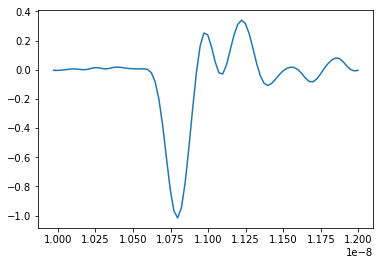

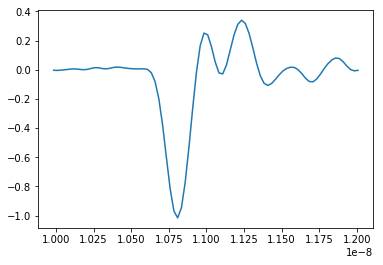

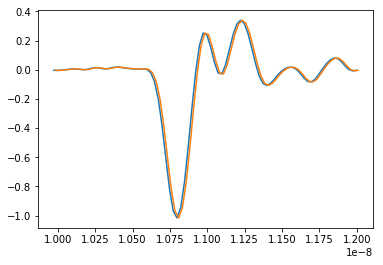

In [10]:
pulsnr = 15

plt.plot(C1["data"][pulsnr][0], C1["data"][pulsnr][1])
plt.show()
plt.plot(C3["data"][pulsnr][0], C1["data"][pulsnr][1])
plt.show()

plt.plot(C1["data"][pulsnr][0], C1["data"][pulsnr][1])
plt.plot(C3["data"][pulsnr][0], C1["data"][pulsnr][1])
plt.show()

### define area of interest

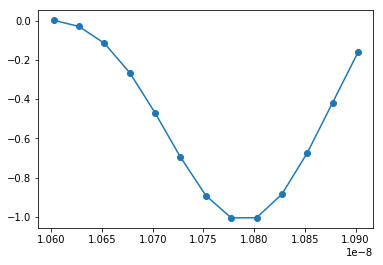

In [11]:
areaMinC1 = 25
areaMaxC1 = 38

plt.plot(C1["data"][0][0][areaMinC1:areaMaxC1], C1["data"][0][1][areaMinC1:areaMaxC1], "-o")
plt.show()

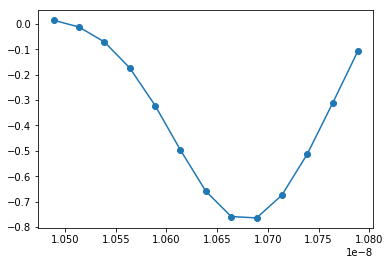

In [12]:
areaMinC3 = 21
areaMaxC3 = 34

plt.plot(C3["data"][0][0][areaMinC3:areaMaxC3], C3["data"][0][1][areaMinC3:areaMaxC3], "-o")
plt.show()

### fit gaussian function

In [13]:
# [A, mu, sigma]
gaussParamsC1 = [-1.5e-11, 1.078e-8, 5e-11]
gaussParamsC3 = [-1.0e-11, 1.07e-8, 5e-11]

In [14]:
C1["fit"] = fitChannel(C1["data"], areaMinC1, areaMaxC1, gaussParamsC1)
C3["fit"] = fitChannel(C3["data"], areaMinC3, areaMaxC3, gaussParamsC3)

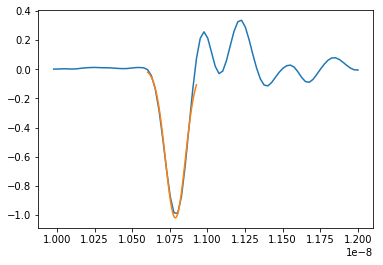

parameter: [-1.68834307e-10  1.07867954e-08  6.60306436e-11] [A, mu, sigma]


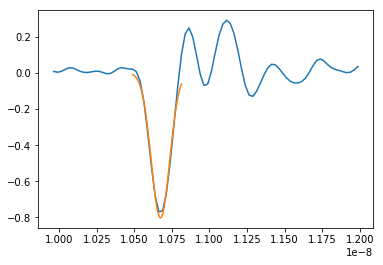

parameter: [-1.23532065e-10  1.06739623e-08  6.14152296e-11] [A, mu, sigma]


In [15]:
pulsNr = 13

plt.plot(C1["data"][pulsNr,0,:],C1["data"][pulsNr,1,:])
xFit = np.linspace(C1["data"][pulsNr,0,areaMinC1], C1["data"][pulsNr,0,areaMaxC1], 50)
plt.plot(xFit, realGaussian(xFit, C1["fit"][pulsNr]))
plt.show()
print("parameter:", C1["fit"][pulsNr], "[A, mu, sigma]")

plt.plot(C3["data"][pulsNr,0,:],C3["data"][pulsNr,1,:])
xFit = np.linspace(C3["data"][pulsNr,0,areaMinC3], C3["data"][pulsNr,0,areaMaxC3], 50)
plt.plot(xFit, realGaussian(xFit, C3["fit"][pulsNr]))
plt.show()
print("parameter:", C3["fit"][pulsNr], "[A, mu, sigma]")

### view mu

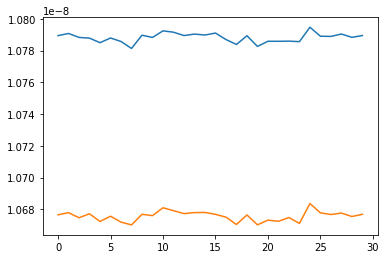

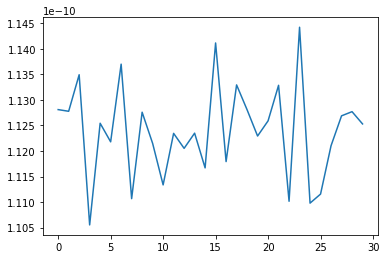

In [16]:
pulseMin = 100
pulseMax = 130

plt.plot(C1["fit"][pulseMin:pulseMax,1])
plt.plot(C3["fit"][pulseMin:pulseMax,1])
plt.show()

plt.plot(C1["fit"][pulseMin:pulseMax,1] - C3["fit"][pulseMin:pulseMax,1])
plt.show()

### filter

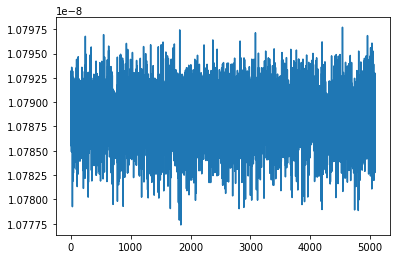

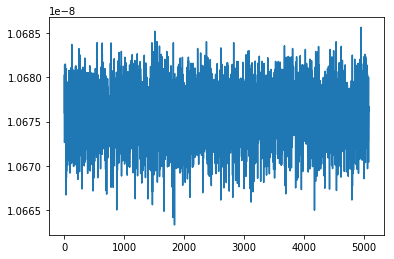

In [17]:
# repeat this chapter until all runaways are removed
# -> no spikes visible in this graphs

plt.plot(C1["fit"][:,1])
plt.show()
plt.plot(C3["fit"][:,1])
plt.show()

In [18]:
#find maximum
maximum = np.argmax(C3["fit"], axis=0)[1]
print(maximum)

4957


In [309]:
#remove this pulse in data and fits, in each channel
C1["data"] = np.delete(C1["data"], maximum, axis=0)
C1["fit"]  = np.delete(C1["fit"],  maximum, axis=0)
C3["data"] = np.delete(C3["data"], maximum, axis=0)
C3["fit"]  = np.delete(C3["fit"],  maximum, axis=0)

### histogram

In [19]:
JitterGauss = C1["fit"][:,1] - C3["fit"][:,1]

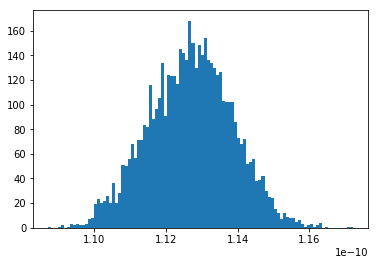

In [20]:
HistY, edges, plot = plt.hist(JitterGauss, 100)
HistX = (edges[1:] + edges[:-1]) / 2

### fit gauss to histogram

In [21]:
# [A, mu, sigma]
gaussParamsHist = [1e-9, 1.13e-10, 1e-12]

In [22]:
HistFitParams = fitSingle(np.array([HistX, HistY]), None, None, gaussParamsHist)

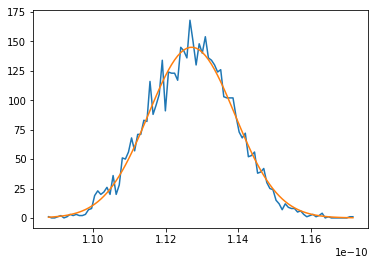

parameter: [4.33981416e-10 1.12716781e-10 1.19348113e-12] [A, mu, sigma]


In [23]:
plt.plot(HistX,HistY)
plt.plot(HistX, realGaussian(HistX, HistFitParams))
plt.show()
print("parameter:", HistFitParams, "[A, mu, sigma]")

## Result

In [25]:
Jitter = HistFitParams[2]

print("Sigma:", Jitter * 1e12, "ps")
print("zwischen beiden Messstrecken")

Sigma: 1.1934811341853262 ps
zwischen beiden Messstrecken


In [26]:
SingleJitter = Jitter / math.sqrt(2)

print("Jitter einer Messstsrecke in dieser Messreihe:")
print(SingleJitter * 1e12, "ps")

Jitter einer Messstsrecke in dieser Messreihe:
0.843918603200656 ps


### save to HDF5-file

In [27]:
#create file
#-> TRUNCATES IF EXISTS!!!
f = h5py.File(h5Path, "w")

In [28]:
#save to file
#-> only possible if data in memory!!!
f_raw = f.create_group("raw")

f_C1  = f_raw.create_group("C1")
i = 0
for shot in C1["data"]:
    dset = f_C1.create_dataset("shot{:05d}".format(i), data = shot)
    for key, value in C1["meta"][i].items():
        try:
            if(type(value) is datetime):
                dset.attrs[key] = value.isoformat()
            else:
                dset.attrs[key] = value
        except:
            print("--- failed for attribute", key, value,"---")
    i += 1

f_C3  = f_raw.create_group("C3")
i = 0
for shot in C3["data"]:
    dset = f_C3.create_dataset("shot{:05d}".format(i), data = shot)
    for key, value in C3["meta"][i].items():
        try:
            if(type(value) is datetime):
                dset.attrs[key] = value.isoformat()
            else:
                dset.attrs[key] = value
        except:
            print("--- failed for attribute", key, value,"---")
    i += 1

    
f_gauss = f.create_group("gaussFit")

f_fit_C1 = f_gauss.create_dataset("gaussFitOnPulse_C1", data = C1["fit"])
f_fit_C1.attrs["axis0"] = "A"
f_fit_C1.attrs["axis1"] = "mu [s]"
f_fit_C1.attrs["axis2"] = "sigma [s]"

f_fit_C3 = f_gauss.create_dataset("gaussFitOnPulse_C3", data = C3["fit"])
f_fit_C3.attrs["axis0"] = "A"
f_fit_C3.attrs["axis1"] = "mu [s]"
f_fit_C3.attrs["axis2"] = "sigma [s]"

f_jitter = f_gauss.create_dataset("jitter_C1-C3", data = JitterGauss)
f_jitter.attrs["axis0"] = "difference in sigma C1 - C3 [s]"

f_hist   = f_gauss.create_dataset("histogramm_jitter", data = np.array((HistX, HistY)))
f_hist.attrs["axis0"] = "Time axis, center of bins. [s]"
f_hist.attrs["axis1"] = "Occurrency []"


f_results = f.create_group("results")
f_resultsGauss = f_results.create_dataset("gauss", data = h5py.Empty("f"))
f_resultsGauss.attrs["sigmaBoth"] = Jitter
f_resultsGauss.attrs["sigmaBothUnit"] = "[s]"
f_resultsGauss.attrs["sigmaSingle"] = SingleJitter
f_resultsGauss.attrs["sigmaSingleUnit"] = "[s]"

In [29]:
f.close()

## - - - playground - - -